# Modelling Brent Price

In [1]:
import pandas as pd
import numpy as np

## Time-series & forecasting models
Traditionally most machine learning (ML) models use as input features some observations (samples / examples) but there is no time dimension in the data.
Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Time-series forecasting is widely used for non-stationary data. Non-stationary data are called the data whose statistical properties e.g. the mean and standard deviation are not constant over time but instead, these metrics vary over time.
These non-stationary input data (used as input to these models) are usually called time-series. Some examples of time-series include the temperature values over time, stock price over time, price of a house over time etc. So, the input is a signal (time-series) that is defined by observations taken sequentially in time.
## The LSTM model
Long short-term memory (LSTM) is an artificial recurrent neural network (RNN) architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It can not only process single data points (e.g. images), but also entire sequences of data (such as speech or video inputs)
This characteristic is extremely useful when we deal with Time-Series or Sequential Data. When using an LSTM model we are free and able to decide what information will be stored and what discarded. We do that using the “gates”. The deep understanding of the LSTM is outside the scope of this post but if you are interested in learning more, have a look at the references at the end of this post.

In [2]:
data=pd.read_csv("data/datewise_news_with_price.csv")

In [3]:
def prev(colm,day):
    l=[]
    for _ in range(int(day)):
        l.extend([np.NaN])
    l.extend(list(colm[:-day]))
    return l

In [4]:
def new_col(datafrm,the_col,upto_previous):
    '''
    datafrm: The dataframe
    the_col: The column which should have previous values
    upto_previous: Upto how many days we should take the previous prices
    '''
    for i in range(upto_previous):
        col_name=the_col.name+str(-i-1)
#         print(len(prev(the_col,i)))
        datafrm[col_name]=prev(the_col,i+1)
    return datafrm

In [5]:
data1 = new_col(data,data.Brent_Close,10).dropna(axis=0)

In [6]:
data1 = data1.reset_index().drop(columns = 'index')

In [7]:
data2 = data1.drop(columns = ['text','sentiment','Wti_Close','Wti_Volume'])

In [8]:
data2

,date,neutral_score,positive_score,negative_score,Brent_Close,Brent_Volume,Brent_Close-1,Brent_Close-2,Brent_Close-3,Brent_Close-4,Brent_Close-5,Brent_Close-6,Brent_Close-7,Brent_Close-8,Brent_Close-9,Brent_Close-10
0,2010-10-27,5.004848,-3.480374,-5.875779,83.59,163.0,83.23,83.66,82.96,81.83,83.60,81.10,82.45,84.53,84.64,83.50
1,2010-10-28,7.814564,-5.796148,-5.507691,83.15,411.0,83.59,83.23,83.66,82.96,81.83,83.60,81.10,82.45,84.53,84.64
2,2010-11-01,1.544746,0.810681,-6.695308,85.41,337.0,83.15,83.59,83.23,83.66,82.96,81.83,83.60,81.10,82.45,84.53
3,2010-11-02,3.366786,-0.777025,-6.400273,86.38,1276.0,85.41,83.15,83.59,83.23,83.66,82.96,81.83,83.60,81.10,82.45
4,2010-11-03,5.098197,-3.602260,-4.911095,88.00,421.0,86.38,85.41,83.15,83.59,83.23,83.66,82.96,81.83,83.60,81.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2434,2022-01-31,4.107919,-1.145803,-5.348387,91.21,10824.0,90.03,89.34,89.96,88.20,86.27,87.89,88.38,88.44,87.51,86.06
2435,2022-02-01,3.324828,-1.544067,-5.665248,91.29,36248.0,91.21,90.03,89.34,89.96,88.20,86.27,87.89,88.38,88.44,87.51
2436,2022-02-02,-6.357212,12.092671,-7.984995,89.47,38172.0,91.29,91.21,90.03,89.34,89.96,88.20,86.27,87.89,88.38,88.44
2437,2022-02-03,5.883592,-4.641930,-3.044854,91.11,33059.0,89.47,91.29,91.21,90.03,89.34,89.96,88.20,86.27,87.89,88.38


In [9]:
y = data2['Brent_Close'] #next_close
cols = ['Brent_Volume', 'Brent_Close-1','Brent_Close-2','Brent_Close-3',
       'Brent_Close-4','Brent_Close-4','Brent_Close-5','Brent_Close-6','Brent_Close-7','Brent_Close-8','Brent_Close-9','Brent_Close-10']
x = data2[cols]

In [10]:
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)

%matplotlib inline

In [11]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data)-1))

# 80% of data will be of training
train_end = int(data_to_use*0.8)

total_data = len(data)
print("total_data:", total_data)

total_data: 2449


In [12]:
y1=y

In [13]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

In [14]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  
y1_test = y1[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train. shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

In [15]:
X_train.shape

(1958, 12, 1)

In [16]:
model = Sequential()
model.add(LSTM(32, input_shape = (len(cols), 1), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
batch_size = 32
nb_epoch = 1000
neurons = 25
dropout = 0.1

model.compile(loss='mean_squared_error' , optimizer='Adam')
model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.2)

Epoch 1/1000
49/49 [==============================] - 3s 15ms/step - loss: 0.1010 - val_loss: 0.0129
Epoch 2/1000
49/49 [==============================] - 0s 9ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/1000
49/49 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 4/1000
49/49 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 5/1000
49/49 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 6/1000
49/49 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 7/1000
49/49 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 8/1000
49/49 [==============================] - 1s 11ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 9/1000
49/49 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 10/1000
49/49 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.00

# MSE Score

In [18]:
score_train = model.evaluate(X_train, y_train, batch_size =1)
score_test = model.evaluate(X_test, y_test, batch_size =1)
print("in train MSE = ", round( score_train ,4)) 
print("in test MSE = ", score_test )

480/480 [==============================] - 1s 2ms/step - loss: 0.0018
in train MSE =  0.0009
in test MSE =  0.0018155041616410017


In [19]:
model_json = model.to_json()
with open("model/model_brent_adam.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model/model_brent_adam.h5")
print("Saved model to disk")

Saved model to disk


In [20]:
pred = model.predict(X_test) 
pred = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))

prediction_data = pred[-1]     

print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(X_test.shape))
print ("Actual output: {}".format(y_test.shape))

print ("prediction data:")
print (prediction_data)

print ("actual data")
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
print (X_test)

Inputs: (None, 12, 1)
Outputs: (None, 1)
Actual input: (480, 12, 1)
Actual output: (480, 1)
prediction data:
[87.7339]
actual data
[[ 3149.      64.06    64.27 ...    62.44    63.3     62.28]
 [39023.      62.43    64.06 ...    60.91    62.44    63.3 ]
 [32863.      62.4     62.43 ...    62.4     60.91    62.44]
 ...
 [38172.      91.29    91.21 ...    87.89    88.38    88.44]
 [33059.      89.47    91.29 ...    86.27    87.89    88.38]
 [33059.      91.11    89.47 ...    88.2     86.27    87.89]]


In [21]:
y1_test

1959    62.43
1960    62.40
1961    60.82
1962    63.00
1963    63.39
        ...  
2434    91.21
2435    91.29
2436    89.47
2437    91.11
2438    93.27
Name: Brent_Close, Length: 480, dtype: float64

In [22]:
l = []
for i in y1_test:
    l.append(i)

In [23]:
l_pred=[i[0] for i in pred]

In [24]:
df= pd.DataFrame({"Original":l,"Predicted":l_pred})

In [25]:
df

,Original,Predicted
0,62.43,63.369217
1,62.40,62.813522
2,60.82,62.149628
3,63.00,60.461033
4,63.39,61.074612
...,...,...
475,91.21,88.964470
476,91.29,88.001282
477,89.47,88.358437
478,91.11,87.583488


<AxesSubplot:>

<Figure size 1224x504 with 0 Axes>

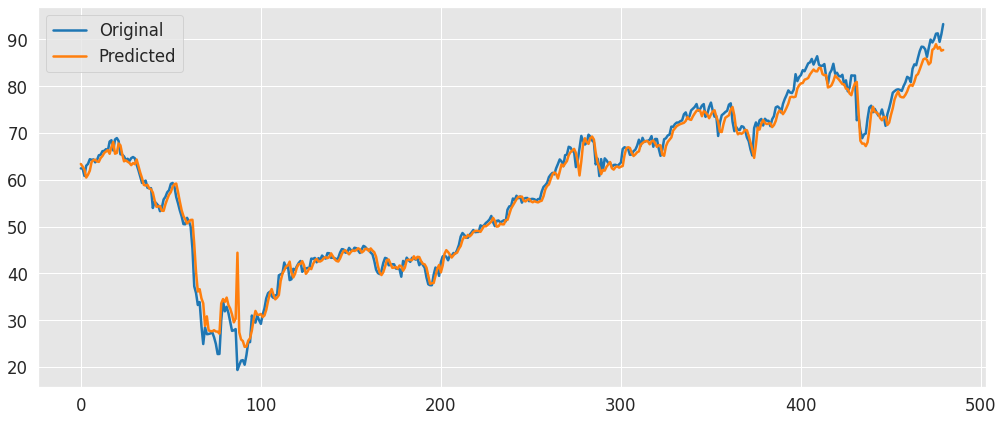

In [26]:
import seaborn as sns
plt.figure(figsize=(17,7))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
df.plot(figsize=(17,7))